In [ ]:
device = 'cuda:1'

In [2]:
from torch import nn
def print_modules(model: nn.Module, depth = 0):
    if depth == 1:
        return
    for name, module in model.named_modules():
        print(''.join(['\t']*depth) + f"{name}")
        print_modules(module, depth+1)

# print_modules(predictor)

In [4]:
import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import random
from matplotlib import pyplot as plt
import uuid


In [5]:
from pathlib import Path
BASE_FOLDER = Path("/media/rustam/data/datasets/matting")
BGR_FOLDER = BASE_FOLDER / "Backgrounds"
TRAIN_FOLDER = BASE_FOLDER / "train"
TEST_FODLER = BASE_FOLDER / "test"

NUM_TRAIN = 479
NUM_TEST = 5

backgrounds = [x for x in BGR_FOLDER.glob("*.jpg") if x.is_file()]
NUM_BGRS = len(backgrounds)

# IMAGE_SIZE = np.array([960, 540]) # TODO my samples are 768x432 -> need to adjust SAM to use this size if possibru
IMAGE_SIZE = np.array([768, 432]) # TODO my samples are 768x432 -> need to adjust SAM to use this size if possibru

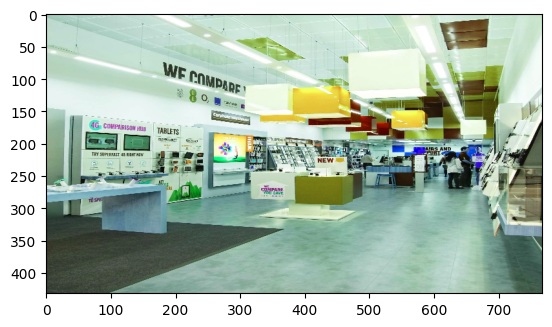

In [6]:
def get_background(num):
    file = backgrounds[num]
    image = cv2.imread(str(file), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_LANCZOS4)
    return image

def get_fgr(num: int, test: bool = False):
    folder = TEST_FODLER if test else TRAIN_FOLDER
    return folder / "fgr" / f"{num:04d}"

def get_mat(num: int, test: bool = False):
    folder = TEST_FODLER if test else TRAIN_FOLDER
    return folder / "pha" / f"{num:04d}+"


image = get_background(10)
plt.imshow(image)


In [11]:
from tqdm.notebook import tqdm
from utils import get_random_points, SamVideoParser
import pickle


In [8]:
PREPARED_FOLDER = Path("/media/rustam/data/matting")

def make_train_video(fgr_no, bgr_no, test=False) -> Path:
    mat_folder = get_mat(fgr_no, test) 
    if not mat_folder.exists():
        return
    if len(list(mat_folder.glob("*.jpg"))) > 800:
        return

    base_dir = PREPARED_FOLDER / f"{fgr_no:04d}-{'a' if test else 'b'}"
    frames_dir = base_dir / "frames"
    matting_dir = base_dir / "matting"
    seg_dir = base_dir / "seg"
    feat_dir = base_dir / "feat"
    
    os.makedirs(str(frames_dir), exist_ok=True)
    os.makedirs(str(matting_dir), exist_ok=True)
    os.makedirs(str(seg_dir), exist_ok=True)
    os.makedirs(str(feat_dir), exist_ok=True)

    background = get_background(bgr_no)

    points = None
    box = None
    for image, matting in tqdm(
        list(
            zip(
                sorted(get_fgr(fgr_no, test).glob("*.jpg")),
                sorted(get_mat(fgr_no, test).glob("*.jpg")),
            )
        ),
        desc="frames and mattings",
    ):
        file = cv2.imread(str(image), cv2.IMREAD_UNCHANGED)
        file = cv2.resize(file, IMAGE_SIZE, interpolation=cv2.INTER_LANCZOS4)
        matt = cv2.imread(str(matting), cv2.IMREAD_UNCHANGED)
        matt = cv2.resize(matt, IMAGE_SIZE, interpolation=cv2.INTER_LANCZOS4)
        matt = matt.mean(axis=2, keepdims=True).astype(np.float32) / 255.0
        result = file * matt + background * (1-matt)
        matt = (matt*255.0).astype(np.uint8)
        cv2.imwrite(str(frames_dir / image.name), result.astype(np.uint8))
        cv2.imwrite(str(matting_dir / image.name), matt)
        if points is None and box is None:
            # im = matt.copy().squeeze()
            # contours, _ = cv2.findContours(
            #     im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            # )
            # contours = sorted(contours, key=cv2.contourArea, reverse=True)[0]
            # poly = cv2.approxPolyDP(contours, 3, True)
            # rect = cv2.boundingRect(poly)
            # cv2.rectangle(
            #     im,
            #     (int(rect[0]), int(rect[1])),
            #     (int(rect[0] + rect[2]), int(rect[1] + rect[3])),
            #     (255, 0, 0),
            #     2,
            # )

            # cv2.imwrite(str(base_dir/"pts.jpg"), im)
            # box = np.array([[rect[0], rect[1]], [rect[0]+rect[2], rect[1]+rect[3]]])
            im = matt.copy().squeeze()
            _, points = get_random_points(im, 30)
            im = np.repeat(im[:,:,None],3,axis=2)
            for p in points:
                cv2.circle(im, p.astype(np.uint)[::-1], 10, (0,0,255), 2, -1)
            cv2.imwrite(str(base_dir/"pts.jpg"), im)

            points = points[:, ::-1].copy()

    predictor = SamVideoParser(device=device)
    if points is not None:
        generator = predictor.video(str(frames_dir), points=points)
    else:
        generator = predictor.video(str(frames_dir), box=box)
        
    for frame_idx, mask_logits, vision_feats, feat_sizes in generator:
        mask_logits -= mask_logits.min()
        mask_logits /= mask_logits.max()
        mask_logits = (mask_logits * 255.0).astype(np.uint8)

        cv2.imwrite(str(seg_dir / f"{frame_idx:05d}.jpg"), mask_logits)

        features = {
            'feats': vision_feats,
            'sizes': feat_sizes
        }

        with open(str(feat_dir /  f"{frame_idx:05d}.pkl"), "wb") as fh:
            pickle.dump(features, fh)

    return base_dir 



In [8]:
for i in tqdm(range(167, 230), desc="create train"):
    path = PREPARED_FOLDER / f"{i:04d}-b"
    # if not path.is_dir():
    #     continue
    make_train_video(i, np.random.randint(0, NUM_BGRS), test=False)

# for i in tqdm(range(min(NUM_TRAIN, 10)), desc="create train"):
#     make_train_video(i, np.random.randint(0, NUM_BGRS), test=False)              

create train:   0%|          | 0/63 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/706 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/706 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/705 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/621 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/621 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/620 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/383 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/383 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/382 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/501 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/501 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/500 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/725 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/725 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/724 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/124 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/124 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/123 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/409 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/409 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/408 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/387 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/387 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/386 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/409 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/409 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/408 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/360 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/360 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/359 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/387 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/387 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/386 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/647 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/647 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/646 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/414 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/414 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/413 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/527 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/527 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/526 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/636 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/636 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/635 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/740 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/740 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/739 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/571 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/571 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/570 [00:00<?, ?it/s]

frames and mattings:   0%|          | 0/723 [00:00<?, ?it/s]

frame loading (JPEG):   0%|          | 0/723 [00:00<?, ?it/s]

propagate in video:   0%|          | 0/722 [00:00<?, ?it/s]

In [9]:
prepared_videos = [x for x in PREPARED_FOLDER.glob("*") if x.is_dir()]

In [10]:
video_dir = prepared_videos[0] / "frames"
matt_dir = prepared_videos[0] / "matting"

In [ ]:
# predictor.reset_state(inference_state)
inference_state = predictor.init_state(video_path=str(video_dir))


In [18]:
# infer some point
# predict mask
# look at it and compare with ground truth - matting
# note - matting is subideal
# note - perhaps we need to improve beyond baseline
# note - should i use another net to generate matting?

In [12]:
files = sorted([x.name for x in video_dir.glob("*.*")])

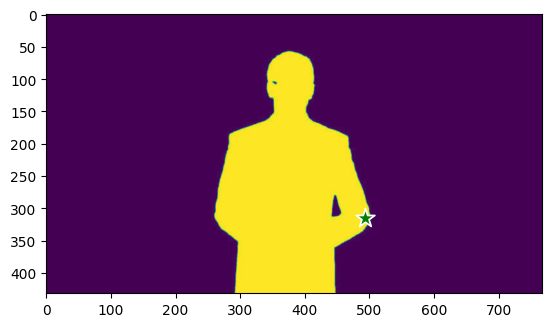

In [13]:
REFERENCE_FRAME = 0
matting_file = str(matt_dir / files[REFERENCE_FRAME])
frame_file = str(video_dir / files[REFERENCE_FRAME])
matting = cv2.imread(matting_file, cv2.IMREAD_UNCHANGED) # .astype(np.float32)/255.0
plt.imshow(matting)

ones_positions = np.argwhere(matting == 255)
random_pos = ones_positions[np.random.choice(len(ones_positions))] # [::-1]
plt.gca().scatter(random_pos[1], random_pos[0], color='green', marker='*', s=200, edgecolor='white', linewidth=1.25)

In [14]:
initial_points = np.array([random_pos[::-1]]).astype(np.float32)
labels = np.array([1], np.int32)

_, out_obj_ids, out_mask_logits, pred_masks, current_vision_feats, current_vision_pos_embeds, feat_sizes, = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=REFERENCE_FRAME,
    obj_id=1,
    points=[initial_points],
    labels=labels,
)

NameError: name 'predictor' is not defined

NameError: name 'out_mask_logits' is not defined

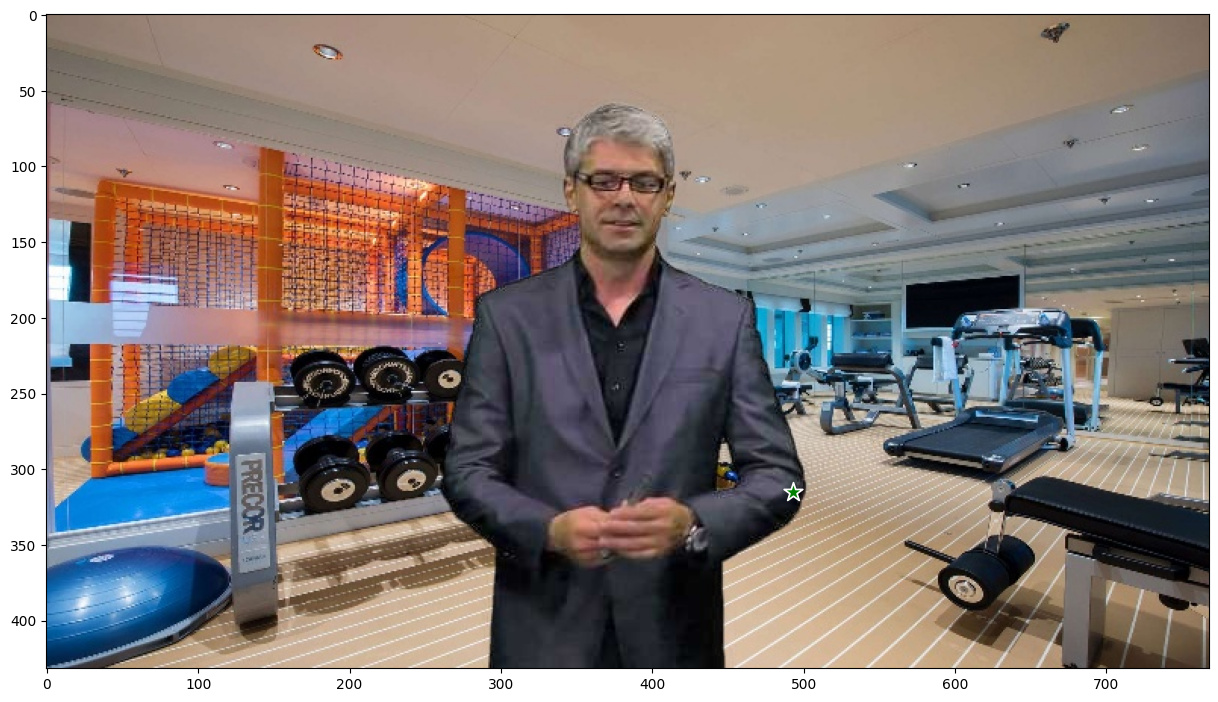

In [15]:
# show the results on the current (interacted) frame
frame = cv2.imread(frame_file, cv2.IMREAD_UNCHANGED) # .astype(np.float32)/255.0
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(15, 9))
plt.imshow(frame)
plt.gca().scatter(
    random_pos[1],
    random_pos[0],
    color="green",
    marker="*",
    s=200,
    edgecolor="white",
    linewidth=1.25,
)

color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
mask = (out_mask_logits[0] > 0.0).cpu().numpy()
h, w = mask.shape[-2:]
mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
plt.gca().imshow(mask_image)


plt.figure(figsize=(15, 9))
plt.imshow(frame)
plt.gca().scatter(
    random_pos[1],
    random_pos[0],
    color="green",
    marker="*",
    s=200,
    edgecolor="white",
    linewidth=1.25,
)

color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
matting_image= (matting.astype(np.float32)/255.0).reshape(h, w, 1) * color.reshape(1, 1, -1)
plt.gca().imshow(matting_image)



In [16]:
plt.figure(figsize=(15, 9))
plt.imshow(out_mask_logits.cpu().numpy()[0].reshape(h, w, -1))


NameError: name 'out_mask_logits' is not defined

<Figure size 1500x900 with 0 Axes>

In [ ]:
current_vision_feats[2].shape

In [ ]:
feat_sizes[2]

In [26]:
q = current_vision_feats[0].cpu().numpy().reshape(*feat_sizes[0], 1, -1)

In [ ]:
q.shape

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(q[:, :, 0, 15])

In [ ]:
w = current_vision_feats[1].cpu().numpy().reshape(*feat_sizes[1], 1, -1)
w.shape


In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(w[:, :, 0, 1])


In [ ]:
current_vision_pos_embeds[0].shape


In [ ]:
q = current_vision_pos_embeds[0].cpu().numpy().reshape(*feat_sizes[0], 1, -1)
plt.figure(figsize=(12, 12))
plt.imshow(q[:, :, 0, 3])